<a href="https://colab.research.google.com/github/suresh-chinta/Santander/blob/master/survival_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy.random as random
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import lifelines
from lifelines import KaplanMeierFitter
class CFG:
    seed = 42    
    img_dim1 = 20
    img_dim2 = 10

    
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})   

# About Dataset

## Why?

  I have created a synthetic dataset for this assignment, as the datasets in public domain, have already been throughly explored
  to be able to produce work that does not look like plagiarized. Besides, I think that creation of dataset is most important activity
  to be done correctly for Survival Analysis, hence I have attempted to create a dataset by myself.
  
## What?
  
  The datset consists of 1000 couples who have married between 2005 and 2010 (inclusive). The couples are observed until 2022 January 1st, to see if they were seperated 
  legally by serving divorce. The objective of this to study years to seperation by divorce.There were also cases of death of one or both partners, during the 
  time between marriage and the year 2022.
  
* couple_id : Identifier for the couple/record
* year_marriage : year of marriage
* is_death : is atleast one of the partner died during study
* death_year : year when death event happend
* are_seperated : is the couple seperate by divorce (0 - not seperated until end of study or censored due to death, 1 - seperated during study)
* year_seperated : year when divorced
* years_together : years together before seperation or death
* is_censored : 1 if no seperation until 2022 or death occured else 0
* religion : 1 - Hinduism, 2 - Christianity, 3 - Islam, 4 - Other

  
  
## Censoring  
  
  Hence the censoring happens for two reasons in this dataset:    
*     Couples who have been observed until 2022, but not seperated. We do not know, if they are seperated beyond 2022.
*     Couples who have experienced a death event and hence dropped from the study. We do not know, if they would be sperated had the event not occured.

  
 The censoring is right censoring because, the true survival times is always equal to or greater than the observed survival time.
 
## Assumption

* Observations that were censored or not is NOT related to probability of event (divorce/seperation) occurance.

In [30]:
import os

In [33]:
os.listdir('.')

['.config', 'sample_data']

In [34]:
!pwd()

/bin/bash: -c: line 1: syntax error: unexpected end of file


### Survival Analysis

* The goal of this analysis to study number of years to Divorce in couples, that were married between 2005 and 2010
* Survival analysis is special in that, even the cases that are not available for entire duration of observation period are not discorded
* Different subjects may enter the study and exit from the study at different points in time





# DataSet generation

In [9]:
couple_id = np.arange(1, 1001)
year_marriage = random.random_integers(2005, 2010, size=1000)
# 10% of couples have a death event
is_death = np.random.choice([0,1], size = 1000, p=[0.9, 0.1])
print(f'number of couples with death event: {sum(is_death)}')
# 30% of couples (of those couples where both partners survived until that year) have divorce event (event of interest of this study)
are_seperated = np.random.choice([0,1], size = 1000, p=[0.7, 0.3])
# if death occured, they are not seperated
are_seperated = np.where(is_death == 1, 0, are_seperated)
religion = np.random.choice([1,2,3,4], size = 1000, p =[0.35, 0.2, 0.1, 0.35])
print(f'number of couples with Divorce event: {sum(are_seperated)}')

number of couples with death event: 74
number of couples with Divorce event: 252


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: This function is deprecated. Please call randint(2005, 2010 + 1) instead
  


In [10]:
def years_together(year_marriage_, are_seperated_, is_death_, death_year_):
    # if death
    if (is_death_ == 1):
        return(death_year_ - year_marriage_)
    
    # if no seperation generate a random number between 
    if (are_seperated_ == 0):
        return(2022 - year_marriage_)
    else:
        # if seperation generate a random number between year_marriage and 2022
        return(np.random.choice(np.arange(1,(2022-year_marriage_))))
    
    

df = pd.DataFrame({
    'couple_id': couple_id,
    #year couple married
    'year_marriage': year_marriage,
    # is the couple seperated by the observation year 2022
    'are_seperated': are_seperated,
    'is_death': is_death,
    'religion' : religion
})
# years the couple is together since their marriage, until the observation year 2022 or until seperated
# for seperated couples, number of years together is generated randomly 
df['death_year'] = df[['is_death', 'year_marriage']].apply(lambda x: 0 if x[0] == 0 else x[1] + np.random.choice(np.arange(1,(2022-x[1]))), axis = 1)
df['years_together'] = df[['year_marriage','are_seperated', 'is_death', 'death_year']].apply(lambda x:years_together(x[0],x[1],x[2],x[3]), axis = 1)
df['year_seperation'] = np.where(((df['is_death'] != 1) & (df['are_seperated'] == 1)), df['year_marriage'] + df['years_together'], 0)
df['years_since_start'] = df['year_marriage'] - 2005
df['is_censored'] = np.where(((df['is_death'] == 1) | (df['are_seperated'] == 0)), 1, 0)

### EDA

In [11]:
import seaborn as sns

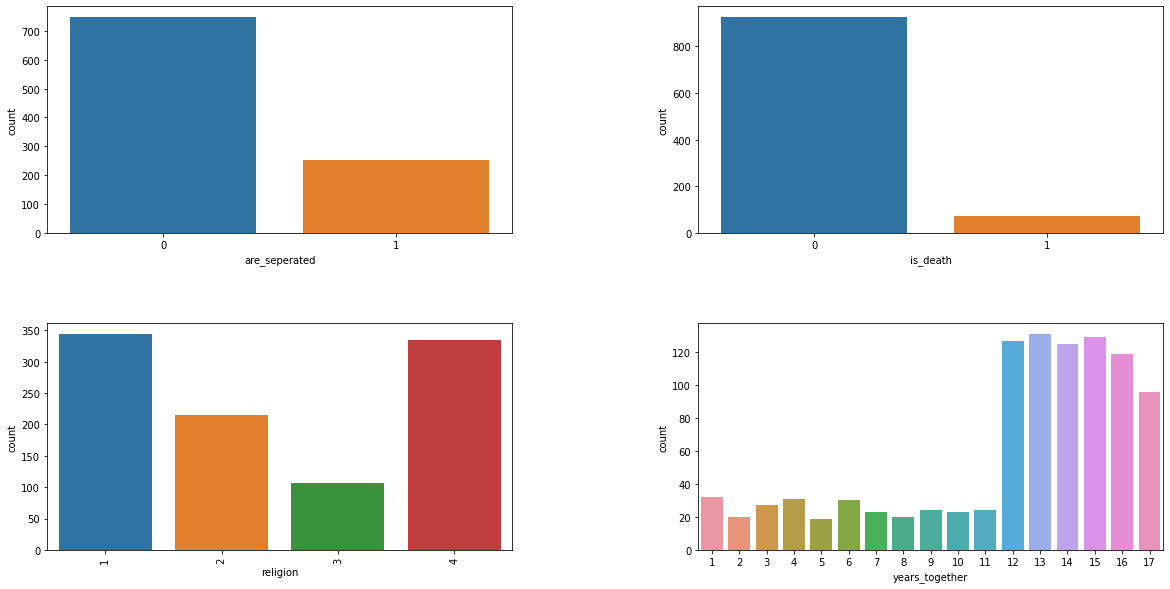

In [12]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 2, 1)
sns.countplot(x=df.are_seperated,ax=ax)
ax = fig.add_subplot(2, 2, 2)
sns.countplot(x=df.is_death,ax=ax)
ax = fig.add_subplot(2, 2, 3)
sns.countplot(x=df.religion,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax = fig.add_subplot(2, 2, 4)
sns.countplot(x=df.years_together,ax=ax)
plt.show();

In [13]:
df.describe()

,couple_id,year_marriage,are_seperated,is_death,religion,death_year,years_together,year_seperation,years_since_start,is_censored
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,2007.525000,0.252000,0.074000,2.432000,149.021000,12.031000,507.707000,2.525000,0.748000
std,288.819436,1.674568,0.434379,0.261902,1.266878,527.418592,4.404025,875.149044,1.674568,0.434379
min,1.000000,2005.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,250.750000,2006.000000,0.000000,0.000000,1.000000,0.000000,11.000000,0.000000,1.000000,0.000000
50%,500.500000,2008.000000,0.000000,0.000000,2.000000,0.000000,13.000000,0.000000,3.000000,1.000000
75%,750.250000,2009.000000,1.000000,0.000000,4.000000,0.000000,15.000000,2006.000000,4.000000,1.000000
max,1000.000000,2010.000000,1.000000,1.000000,4.000000,2021.000000,17.000000,2021.000000,5.000000,1.000000


In [14]:
# none who have this combination, which is as it should be 
df.loc[((df['is_death'] == 1) & (df['are_seperated'] == 1))]

,couple_id,year_marriage,are_seperated,is_death,religion,death_year,years_together,year_seperation,years_since_start,is_censored


In [15]:
df.loc[df['are_seperated'] == 0].head()

,couple_id,year_marriage,are_seperated,is_death,religion,death_year,years_together,year_seperation,years_since_start,is_censored
1,2,2007,0,0,4,0,15,0,2,1
3,4,2009,0,0,4,0,13,0,4,1
4,5,2010,0,0,3,0,12,0,5,1
7,8,2007,0,0,4,0,15,0,2,1
8,9,2008,0,0,2,0,14,0,3,1


In [16]:
df.loc[df['are_seperated'] == 1].head()

,couple_id,year_marriage,are_seperated,is_death,religion,death_year,years_together,year_seperation,years_since_start,is_censored
0,1,2008,1,0,4,0,12,2020,3,0
2,3,2005,1,0,2,0,9,2014,0,0
5,6,2007,1,0,2,0,5,2012,2,0
6,7,2006,1,0,1,0,4,2010,1,0
13,14,2007,1,0,1,0,10,2017,2,0


In [17]:
df.loc[df['is_death'] == 1].head()

,couple_id,year_marriage,are_seperated,is_death,religion,death_year,years_together,year_seperation,years_since_start,is_censored
20,21,2010,0,1,1,2020,10,0,5,1
26,27,2008,0,1,3,2017,9,0,3,1
46,47,2008,0,1,3,2011,3,0,3,1
51,52,2008,0,1,4,2019,11,0,3,1
52,53,2005,0,1,4,2007,2,0,0,1


In [18]:
import matplotlib.pyplot as plt

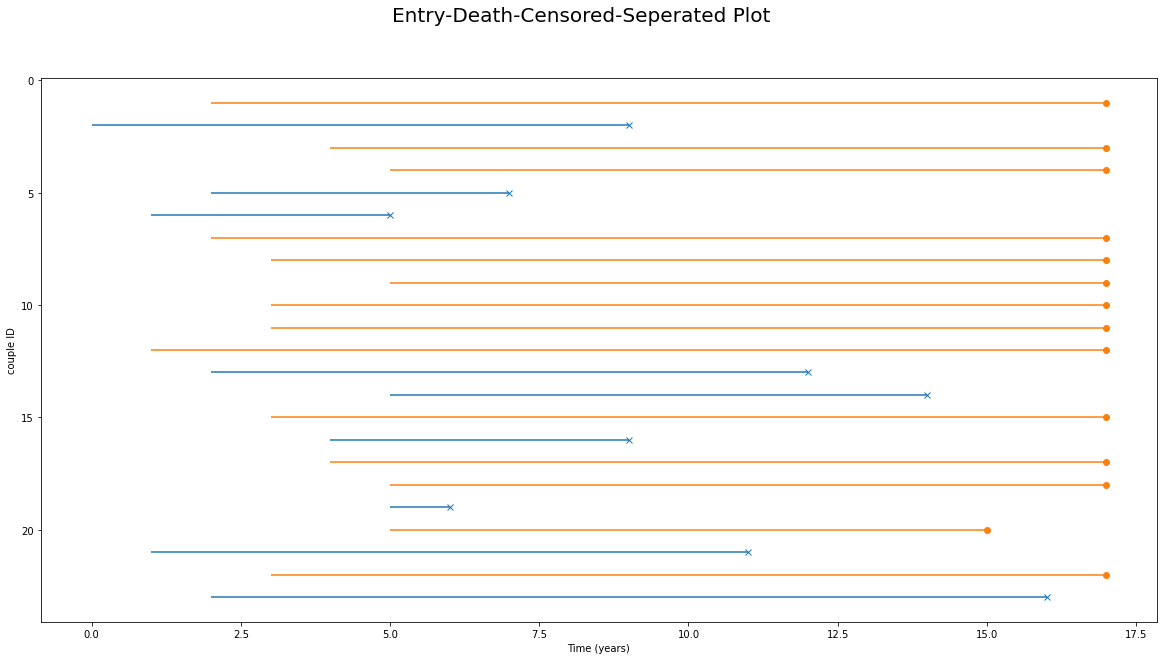

In [19]:
    for y, row in df.iloc[1:24,].iterrows():
        start = row['years_since_start']
        end = row['years_since_start'] + row['years_together']
        
        if row['are_seperated'] == 1:
            status = 1
        elif row['is_death'] == 1 or row['are_seperated'] == 0:
            status = 0
            
        if status == 1:
            # when event (divorce occured)
            plt.hlines(y, start, end, color='C0')
            plt.plot(end, y, marker='x', color='C0')
        else:
            # When data is sensored either due to death or reaching the maximum of observation period without event
            plt.hlines(y, start, end, color='C1')
            plt.plot(end, y, marker='o', color='C1')
            
    plt.xlabel('Time (years)')
    plt.ylabel('couple ID')
    plt.gca().invert_yaxis()
    plt.suptitle('Entry-Death-Censored-Seperated Plot', fontsize = 20);

### The X indicates occurance of event
### The O indicates observation censored


## Analysis

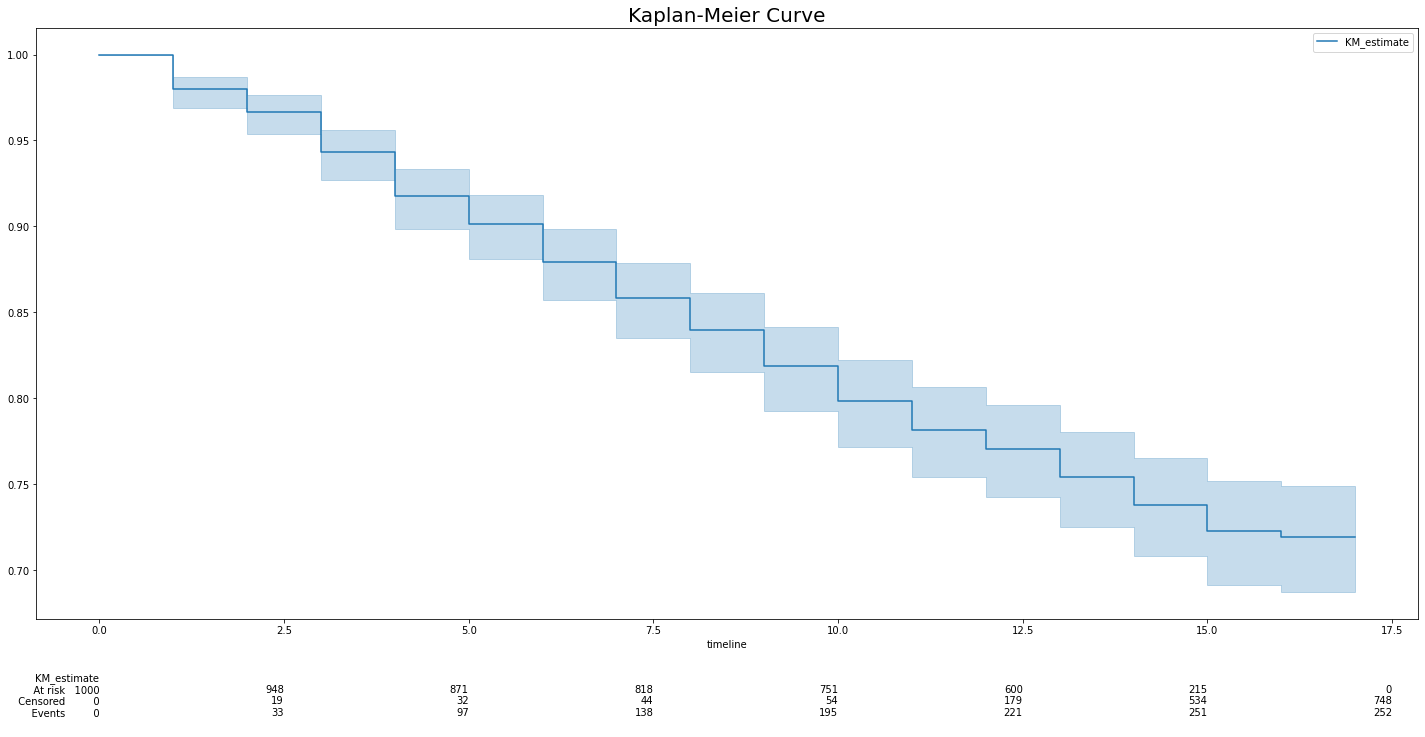

In [20]:
kmf = KaplanMeierFitter()
kmf.fit(durations = df['years_together'],
        event_observed=df['are_seperated'],
       )
kmf.plot(at_risk_counts=True)
plt.title('Kaplan-Meier Curve', fontsize = 20);

### As can be seen from the curve above, over 75% of couples are not divorced before 13 years
### And over 70% of couples did not divorce before end the end of study period
### The curve does not have significantly variable drops at different periods, however has a stair case pattern (because that is how the data was generated)

In [21]:
(df['is_death'] == 1).sum() + \
        ((df['is_death'] != 1) & (df['are_seperated'] == 0)).sum()

748

### Compare years to seperation between couples of different regions (Kaplan Meier)

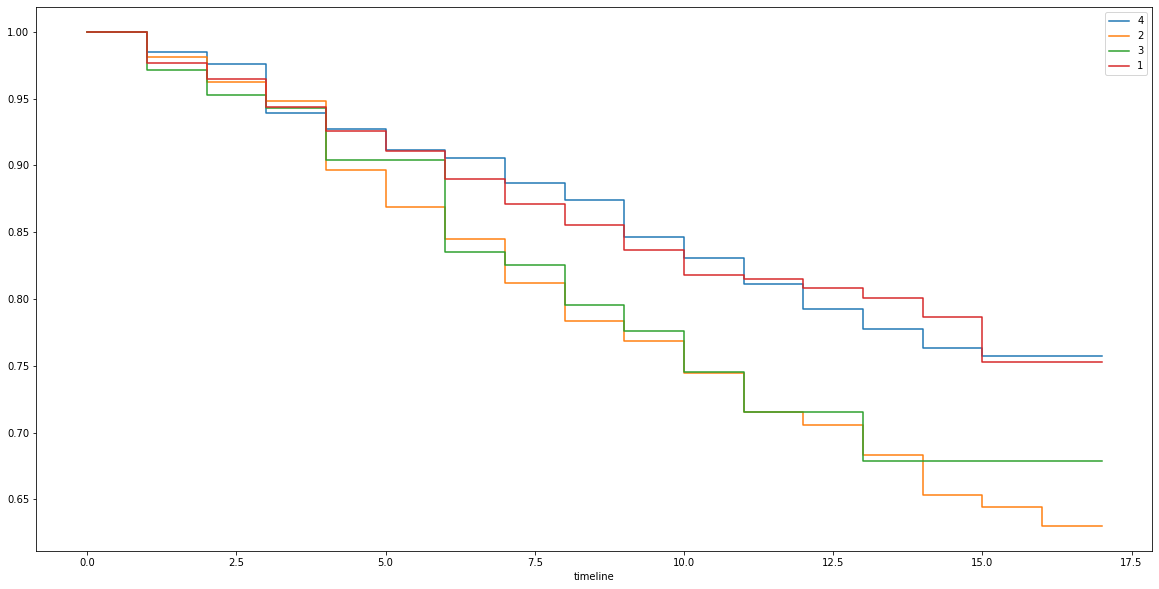

In [22]:
ax = plt.subplot(111)

kmf = KaplanMeierFitter()

for religion in df['religion'].unique():
    
    flag = df['religion'] == religion
    
    kmf.fit(df.loc[flag]['years_together'], event_observed = df.loc[flag]['are_seperated'], label = religion, )
    kmf.plot(ax=ax, ci_show = False)

### It can been observed that the numbe or years of survival of marriage among Religion - 1 (Hindus) is relatively lower compared to the other 3 religions, let us check if the differnce is significance**

### Compare years to seperation between couples of different regions (logrank test)

In [23]:
from lifelines.statistics import logrank_test, pairwise_logrank_test


religion_flag_1 = df['religion'] == 1
religion_flag_2 = df['religion'] == 2
religion_flag_3 = df['religion'] == 3
religion_flag_4 = df['religion'] == 4

T = df.are_seperated
E = df.years_together


results = logrank_test(E[religion_flag_1], 
                       E[religion_flag_4], 
                       T[religion_flag_1], 
                       T[religion_flag_4])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.03 0.86      0.22

### No reason to reject the null hypothesis  (survival curves being identical)  as p value is not significant between religin 1 (Hinduism) and religion 4 (Other than Hindu, Christinaty and Islam).

In [24]:
results = pairwise_logrank_test(df['years_together'], df['religion'], df['are_seperated'])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
     test_statistic      p  -log2(p)
1 2            8.62 <0.005      8.23
  3            3.43   0.06      3.96
  4            0.03   0.86      0.22
2 3            0.17   0.68      0.56
  4            7.78   0.01      7.56
3 4            3.06   0.08      3.64

### No reason to reject the null hypothesis  (survival curves being identical)  as p value is not significant between any two pair of religions. As p values are not significant.

## Kaplan-Meier summary:

### Pros:
    flexible, minimal assumptions
    fast

### Cons:
   * Not useful for prediction
    Curve is not smooth*

### Cox Proportionate Hazards Model

In [25]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(df[['years_together', 'are_seperated', 'religion']],
        duration_col='years_together',
        event_col='are_seperated')

<lifelines.CoxPHFitter: fitted with 1000 total observations, 748 right-censored observations>

In [26]:
cph.print_summary(columns=["coef","exp(coef)","exp(coef) lower 95%","exp(coef) upper 95%", "z", "p"], decimals=3)

<lifelines.CoxPHFitter: fitted with 1000 total observations, 748 right-censored observations>
             duration col = 'years_together'
                event col = 'are_seperated'
      baseline estimation = breslow
   number of observations = 1000
number of events observed = 252
   partial log-likelihood = -1682.182
         time fit was run = 2022-08-30 20:56:49 UTC

---
            coef  exp(coef)  exp(coef) lower 95%  exp(coef) upper 95%      z     p
covariate                                                                         
religion  -0.007      0.993                0.901                1.094 -0.147 0.883
---
Concordance = 0.497
Partial AIC = 3366.364
log-likelihood ratio test = 0.022 on 1 df
-log2(p) of ll-ratio test = 0.180

### CPH can be used to predit survial times of cases in test sample, if the dataset is split into train, test sets

## Summary

#### Survival Analyis to be used when there is time to event data and censorship of observations
#### such as below
* Time to employee churn
* Time to machine failure
* Time to a personal event (Child birth)
#### There are both parametric (COX) and non parametric (Kaplan Meier) techniques to apply on such dataset